# TP 3 LSD Mehdaoui

## 1-X-Ray Tomography

In [1]:
import numpy as np
import scipy
import scipy.sparse.linalg as ssl
import scipy.io as scio
import matplotlib.pyplot as plt
import time
lmb = 0.13
delta = 0.02

### Question 1.1

In [2]:
H = scio.loadmat('data/H.mat')['H']
xbar = scio.loadmat('data/x.mat')['x']
G = scio.loadmat('data/G.mat')['G']

### Question 1.2 

In [3]:
Hx = H @ xbar
y = Hx + np.random.normal(size = Hx.shape, scale = 1)

### Question 1.3

In [4]:
x_im = xbar.reshape((90,90), order = 'F')
y_im = y.reshape((90,180), order = 'F')

<bound method Figure.show of <Figure size 432x288 with 2 Axes>>

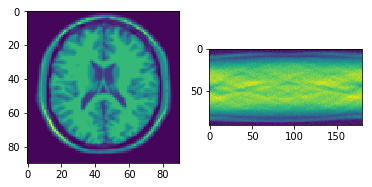

In [5]:
fig , ax = plt.subplots(1,2)
ax[0].imshow(x_im)
ax[1].imshow(y_im)
fig.show

In [6]:
Ht = np.transpose(H)
Gt = np.transpose(G)
N = 90*90
M = 90*180

## 2-Optimization problem

On cherche 
$$ \hat{x} = argmin f(x) $$
$$ \hat{x} = argmin \frac{1}{2}||Hx-y||^2 +\lambda r(x) $$

Avec $$ r(x) = \sum\limits_{n=1}^{2N} \sqrt{1+\frac{(Gx)_{n}^{2}}{\delta^2}} $$

La fonction f est différentiable, on peut donc calculer son gradient :
$$ \nabla f(x)= H^T (Hx-y)+ \lambda G^T \frac{Gx}{\delta^2 \sqrt{1+\frac{(Gx)^2}{\delta^2}}}$$

On s'apperçoit alors que $\nabla f$ est Lipschitzienne. 

En effet :
$$ |\nabla f(x_1)-\nabla f(x_2)|=|H^T (Hx_1-y)+ \lambda G^T \frac{Gx_1}{\delta^2 \sqrt{1+\frac{(Gx_1)^2}{\delta^2}}}-H^T (Hx_2-y)+ \lambda G^T \frac{Gx_2}{\delta^2 \sqrt{1+\frac{(Gx_2)^2}{\delta^2}}}|$$
$$ |\nabla f(x_1)-\nabla f(x_2)|\leq |H^T H(x_1-x_2)| + |\lambda G^T \frac{G(x_1 - x_2}{\delta^2}|$$ 
$$ |\nabla f(x_1)-\nabla f(x_2)|\leq L \ |x_1-x_2| $$
$$ avec \ \ L=||H||^2+\frac{\lambda}{\delta^2}||G||^2$$

### Question 2.2

In [7]:
def grad_f(x):
    
    x = np.reshape(x, (8100,1))
    
    psi = lambda u : np.sqrt(1+(u/delta)**2)
    psi_prime = lambda u : (u/(delta**2))*1/(psi(u))
    
    grad_r = Gt.dot(psi_prime(G.dot(x)))
    grad_norm = Ht.dot(H.dot(x)-y)
    return grad_norm + lmb*grad_r

### Question 2.3

In [8]:
Lipsch = ssl.svds(H)[1][-1]**2 + (lmb/delta**2)*ssl.svds(G)[1][-1]**2
print(Lipsch)

18092.773276864784


## 3-Optimization algorithm

In [9]:
x0 = np.zeros([N,1])

In [10]:
def cost(x,delta,lmb):
    norm = (np.linalg.norm(H.dot(x)-y))**2/2
    psi = sum(np.sqrt(1+(G.dot(x)/delta)**2)) 
    return norm+lmb*psi

### 3.1 Gradient descent algorithm

In [12]:
def grad_descent(lmb, delta):
    xn = x0

    it = 0
    
    converged = False
    gamma = 1/Lipsch
    temps = []
    critere = []
    debut = time.time()
    
    while converged == False:
        it += 1
        xnp1 = xn-gamma*grad_f(xn)
        tol = np.linalg.norm(grad_f(xn))
        if it%1000 == 0:
            print(it, tol)
        if tol<np.sqrt(N)*1e-4:
            converged = True
        xn = xnp1
        fin = time.time()
        temps.append(fin-debut)
        critere.append(cost(xn,delta,lmb))
    return [xn, temps, critere]
sol_gd = grad_descent(lmb, delta)

1000 6.753907519283893
2000 0.8688935686078287
3000 0.16614937832317686
4000 0.03773850417040617
5000 0.009532359251132267


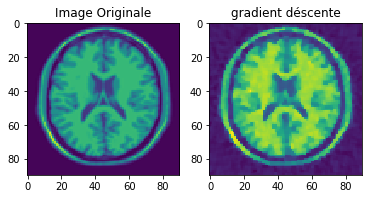

In [13]:
fig, ax = plt.subplots(1,2)
ax[0].set_title('Image Originale')
ax[0].imshow(x_im)
ax[1].set_title('gradient déscente')
ax[1].imshow(sol_gd[0].reshape(90,90,order='F'))

## 3.2 MM-Algorithm

On a f 2 fois differentiable. 
Donc $A − \nabla^2 f(x)$ est semi definie positive x:

$$ \forall \in R,  f(x) \leq f(y) + \nabla{f}(y)^T(x-y) + \frac{1}{2}(x-y)^T A(x-y)$$

La hessienne de $\|Hx-y\|^2$ est $H^TH$. 

On a donc que  $$  \forall \in R,  \|Hx-y\|^2 \leq \|Hx-y\|^2 + \nabla{\|Hx-y\|^2}(y)^T(x-y) + \frac{1}{2}(x-y)^TH^TH(x-y)$$

On a aussi $\lambda \sum \psi$ une fonction paire et differentiable donc $\forall u \in R:$
De plus on a les propriétés suivantes  : <br>
$ \psi(u) = \psi(|u|) $ <br>
$ \psi(\sqrt(.))= \sqrt{1 + \frac{|.|}{\delta^2}}$ est concave <br>
$ \frac{\partial\psi(u)}{\partial u} = \frac{u}{\delta\sqrt{1 + (\frac{u}{\delta})^2}} ≥ 0$ Donc la limoite en 0 vaut $\frac{1}{\delta} \in R $

On a $\lambda \nabla^2  \sum \psi ≤ \frac{\lambda}{\delta^2}G^T Diag(\frac{\psi'[Gx]^{i}}{[Gx]^{i}})G$


On en déduit qu'un majorant pour f est :

$$ f(x) \leq f(y) + \nabla{f}(y)^T(x-y) + \frac{1}{2}(x-y)^T A (x)(x-y)$$
<br>
Avec $$  A(x)=H^TH + \frac{\lambda}{\delta^2}G^T Diag(\frac{\psi'[Gx]^{i}}{[Gx]^{i}})G$$

In [17]:
def curv(x, lmb, delta):
    x = np.reshape(x, (N,1))
    lmb, delta = lmb, delta
    Diag_psi = scipy.sparse.diags((1/np.sqrt(1+(G.dot(x)/delta)**2))[:,0]).tocsc()
    Operator = lambda u: H.T.dot(H.dot(u)) + (lmb/delta**2)*Gt.dot(Diag_psi.dot(G.dot(u)))
    Linear_op = ssl.LinearOperator((N,N), matvec=Operator , rmatvec = Operator)
    return Linear_op

def MM_algo(theta, lmb, delta):
    
    xn = np.zeros((N,1))
    
    it = 0
    
    converged = False
    temps = []
    critere = []

    debut = time.time()    
    
    while  converged == False:
        it += 1
        
        xnp1 = xn-theta*np.reshape(ssl.bicg(curv(xn, lmb=lmb, delta=delta), grad_f(xn))[0],(N,1))
        tol = np.linalg.norm(grad_f(xn))
        if it%10 == 0:
            print(it, tol)
        
        if tol<np.sqrt(N)*1e-4:
            converged = True
        fin = time.time()
        xn = xnp1
        temps.append(fin-debut)
        critere.append(cost(xn,delta,lmb))
    
    
    return [xn, temps, critere]

sol_MM = MM_algo(1, lmb, delta)

10 19.923622775707635
20 2.786993046205119
30 0.6839642626997016
40 0.20833607785264036
50 0.06994246224479633
60 0.024725975702635974
70 0.009039176259399564


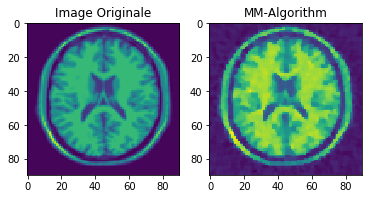

In [18]:
fig, ax = plt.subplots(1,2)
ax[0].set_title('Image Originale')
ax[0].imshow(x_im)
ax[1].set_title('MM-Algorithm')
ax[1].imshow(sol_MM[0].reshape(90,90,order='F'))

## 3.6-Comparison 

Text(0.5,0,'temps en secondes')

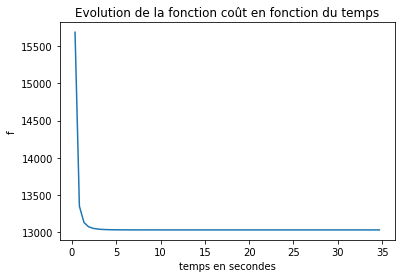

In [39]:
plt.plot(sol_MM[1], sol_MM[2])
plt.title('Evolution de la fonction coût en fonction du temps')
plt.ylabel('f')
plt.xlabel('temps en secondes')

Text(0.5,0,'temps en secondes')

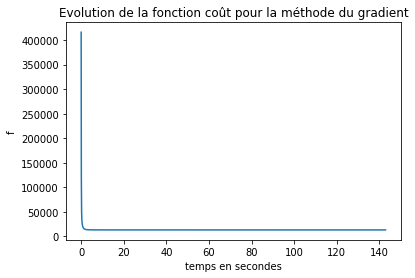

In [38]:
plt.plot(sol_gd[1], sol_gd[2])
plt.title('Evolution de la fonction coût pour la méthode du gradient')
plt.ylabel('f')
plt.xlabel('temps en secondes')

In [21]:
def SNR(x):
    return 10*np.log10(np.linalg.norm(xbar)**2/np.linalg.norm(xbar-x)**2)

In [26]:
print('SNR pour l\'algorithm MM')
print(SNR(sol_MM[0]))
print('SNR pour la méthode du gradient')
print(SNR(sol_gd[0]))

SNR pour l'algorithm MM
18.859543244251668
SNR pour la méthode du gradient
18.859573429521994


In [37]:
print("Nb d'itérations pour la décente de gradient")
print(len(sol_gd[1]))
print("Temps d\'éxecution pour la décente de gradient")
print(sol_gd[1][-1])

print("Nb d'itérations pour l\'algorithm MM")
print(len(sol_MM[1]))
print("Temps d\'éxecution pour l\'algorithm MM")
print(sol_gd[1][-1])

Nb d'itérations pour la décente de gradient
5044
Temps d'éxecution pour la décente de gradient
142.91189885139465
Nb d'itérations pour l'algorithm MM
71
Temps d'éxecution pour l'algorithm MM
142.91189885139465


In [ ]:
delta_liste = [0.01,0.1,1,10,100,1000]
lmb_liste = [0.01,0.1,1,10,100,1000]
best_lmb = 0
best_delta = 0
best_SNR = 1000

for i in delta_liste:
    for j in lmb_liste:
        sol_MM = MM_algo(1, i, j)
        if SNR(sol_MM[0]) < best_SNR:
            best_delta = i
            best_lmb = j
            best_SNR = SNR(sol_MM[0])

### Conclusion

On constate que les deux méthodes étudiées aboutissent sur une version acceptable de l'image originale avec un SNR d'environ 18.86.

La décente de gradient a l'avantage de ne pas nécessiter trop de calculs préalables (gradient et constante de Lipchitz) mais son temps d'exécution est important (2 minutes pour 5044 itérations).

À l'inverse, l'algorithme MM quadratique nécessite de calculer une fonction majorant mais il converge plus rapidement et avec moins d'itérations (34s pour 71 itérations).
